# Imports and Data Loading

In [1]:
import numpy as np
import pandas as pd
import bayesian_multitarget_latent_factors as bmlf
import arviz as az

doInference = False # if False just do the analysis of the idata.nc file

"""
A copy of the discussed dataset can be found at
https://lib.stat.cmu.edu/datasets/tecator
"""

df = pd.read_csv('tecator_data.csv')
df = df[0:100]
df_abs = df.loc[:,[col for col in df.columns if 'Absorbance' in col]]
df_abs.columns = np.round( np.linspace(850, 1050, 100) )
df_abs = df_abs[df_abs.columns[::3]] #subsampling
df_targets = df.iloc[:,-3:]
data_dic = \
bmlf.one_functional_target_dictionary_builder(
    175,
    N = df_targets.shape[0],
    L1= 3 ,
    L2 = df_abs.shape[1],
    domain_range_2=[850,1050],
    p2 = 10,
    r = 1,
    X_scale_multiplier=0.0,
)
data_dic['y1'] = df_targets.values.T
data_dic['y2'] = df_abs.values.T

/tmp/ipykernel_10552/3398689072.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Generate inference data netCDF file

In [2]:
if doInference:
    idata = \
    bmlf.sample_from_posterior(data_dic, 1997, output_dir='./02_tecator_dataset', do_prior_sampling=False)
    
    az.to_netcdf(idata, './02_tecator_dataset/idata.nc')

    data_dic['k'] = 2
    
    idata_lowK = \
    bmlf.sample_from_posterior(data_dic, 7991, output_dir='./02_tecator_dataset/lowK', do_prior_sampling=False)

    az.to_netcdf(idata_lowK, './02_tecator_dataset/lowK/idata.nc')

    data_dic['k'] = 6
    
    idata_highK = \
    bmlf.sample_from_posterior(data_dic, 42, output_dir='./02_tecator_dataset/highK', do_prior_sampling=False)

    az.to_netcdf(idata_highK, './02_tecator_dataset/highK/idata.nc')

    raise Exception("Stop the execution here!")

# Explore the inference data file

In [3]:
from bspline_generated_plotting import *
import numpy as np
from bayesian_multitarget_latent_factors.HMC_helper import get_expected_log_likelihood
from ipywidgets import interact, widgets

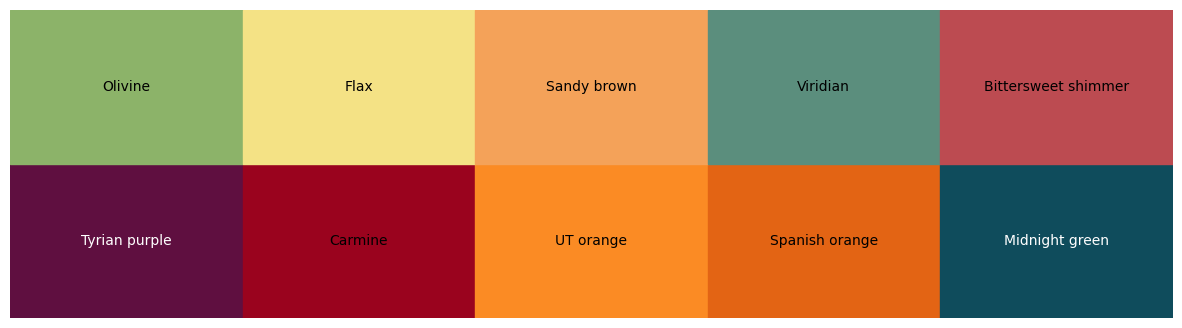

In [4]:
show_palette()

In [5]:
# load the inference dataset
idata = az.from_netcdf("./02_tecator_dataset/idata.nc")
idata_lowK = az.from_netcdf("./02_tecator_dataset/lowK/idata.nc")
idata_highK = az.from_netcdf("./02_tecator_dataset/highK/idata.nc")

In [6]:
# Apply the Varimax + Signed Permutation algorithm for interpretation
Varimax_res_xr = bmlf.Varimax_RSP(idata)

Rotated sample 0
Rotated sample 500
Rotated sample 1000
Rotated sample 1500
Rotated sample 2000
Rotated sample 2500
Rotated sample 3000
Rotated sample 3500
Starting iteration number 0
	 Previous objective fun =	inf
	 New objective fun =		331144.882
Starting iteration number 1
	 Previous objective fun =	331144.882
	 New objective fun =		72593.269
Starting iteration number 2
	 Previous objective fun =	72593.269
	 New objective fun =		72583.981
Starting iteration number 3


## Check for outliers

In [7]:
get_expected_log_likelihood(idata, ['y_posterior'])

-6463.063877132532

In [8]:
elpd = az.loo(idata, var_name='y_posterior')

In [9]:
elpd

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6490.28   104.68
p_loo       18.52        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [10]:
elpd_lowK = az.loo(idata_lowK, var_name='y_posterior')

In [11]:
elpd_lowK

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6488.63   104.87
p_loo       18.42        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       98   98.0%
 (0.5, 0.7]   (ok)          2    2.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [12]:
elpd_highK = az.loo(idata_highK, var_name='y_posterior')

In [13]:
elpd_highK

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6491.28   104.64
p_loo       17.95        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### Try other techniques for model comparison using WAIC

array([[<Axes: title={'center': 'k = 2 - k = 4'}, ylabel='ELPD difference'>,
        <Axes: >],
       [<Axes: title={'center': 'k = 2 - k = 6'}, ylabel='ELPD difference'>,
        <Axes: title={'center': 'k = 4 - k = 6'}>]], dtype=object)

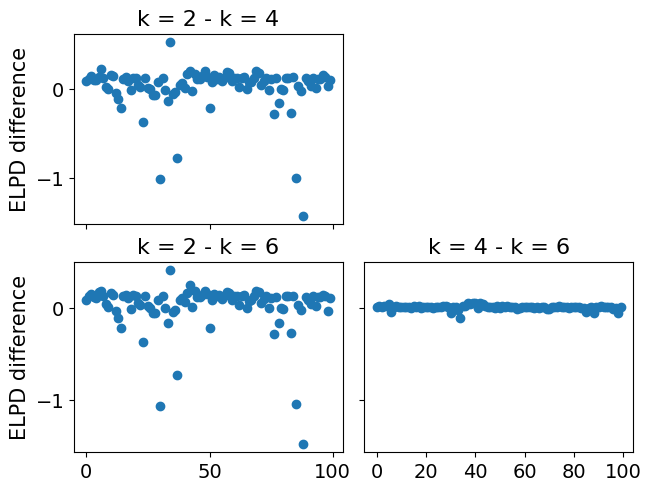

In [14]:
az.plot_elpd({
    'k = 2':idata_lowK,
    'k = 4':idata,
    'k = 6':idata_highK
}, var_name='y_posterior', ic='loo')

/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indicati

array([[<Axes: title={'center': 'k = 2 - k = 4'}, ylabel='ELPD difference'>,
        <Axes: >],
       [<Axes: title={'center': 'k = 2 - k = 6'}, ylabel='ELPD difference'>,
        <Axes: title={'center': 'k = 4 - k = 6'}>]], dtype=object)

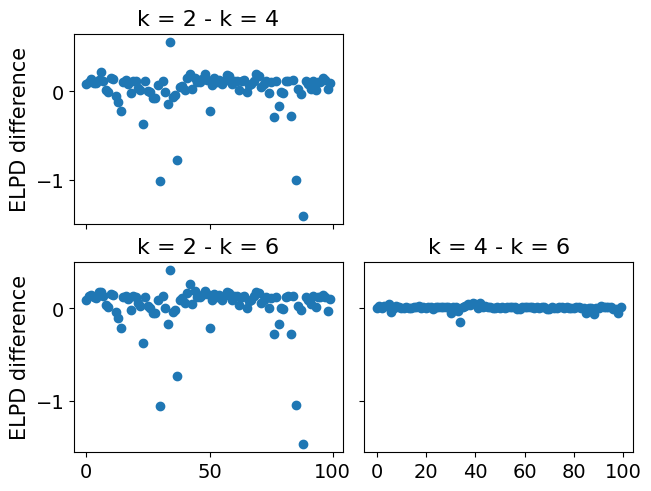

In [15]:
az.plot_elpd({
    'k = 2':idata_lowK,
    'k = 4':idata,
    'k = 6':idata_highK
}, var_name='y_posterior', ic='waic')

In [16]:
az_compare_res = \
az.compare({
    'k = 2':idata_lowK,
    'k = 4':idata,
    'k = 6':idata_highK    
}, var_name='y_posterior', ic='waic'
)

/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indicati

In [17]:
az_compare_res

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
k = 2,0,-6488.539368,18.329365,0.000000,8.013029e-01,104.852346,0.000000,True,log
k = 4,1,-6490.303798,18.543976,1.764429,1.986971e-01,104.701394,2.508311,True,log
k = 6,2,-6491.237415,17.909374,2.698047,2.220446e-16,104.631797,2.567892,True,log


/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

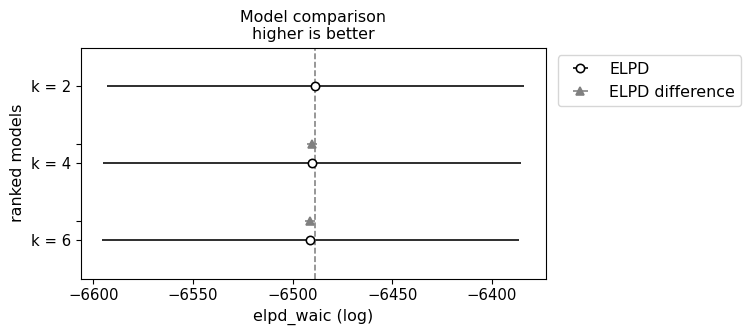

In [18]:
az.plot_compare(az_compare_res)